# Intelligente systemer: Transfer Learning using EfficientNet
Welcome to this notebook which is part of Kristiania University College's course «Utvikling og anvendelse av intelligente systemer», module 5, «Dyp læring og overføringslæring».

## How to use this notebook
This is a Jupyter notebook with text and Python code that you run by pressing shift-enter. The purpose is to become familiar with relevant concepts in practice, not necessarily to understand all the details of the code. Take the time to read the text, review the code, run the code cells (make sure they are in the correct order), study the results, and think about what we do, why and how.

At the end of this notebook, you will find five self-test questions _in italics_. Go to Canvas and answer the questions after completing the notebook.

## The problem: Training a flower classifier
This notebook trains a classifier using 210 images from the [Flowers image dataset](https://www.kaggle.com/olgabelitskaya/flower-color-images) belonging to 10 classes. Instead of building and training the model from scratch, it uses a pre-trained model, namely, [Google's EfficientNet](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html) as a base. The knowledge accumulated in the base model (trained on a large image dataset with 1000 object classes) is transfered to classify flower images by species. [Adopted from [Serge Korzh](https://kiwee.eu/)]

## 1. Imports

In this notebook we'll need:
- `h5py` and `numpy` for data loading and manipulation
- `tensorflow`, `keras` and `efficientnet` for model training
- `matplotlib` for data visualisation. 
- [efficientnet](https://github.com/qubvel/efficientnet) that includes the model architecture.

In [1]:
# Note: There is a bug on some systems that may affect this notebook.
# If you get a «Kernel Restarting» error message when running this notebook,
# uncomment the code below (i.e. remove the hash signs in the beginning of the
# code lines). Then restart the kernel and rerun the entire notebook from here.

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
!pip install efficientnet

In [3]:
#H5 (or HDF5) stands for Hierarchical Data Format version 5, an open source file format that supports large, complex, 
#heterogeneous data. It uses a "file directory" like structure to organize data
import h5py
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
# import the tensorflow.keras version of efficientnet
from efficientnet import tfkeras as efficientnet
import matplotlib.pyplot as plt

## 2. Loading data

We'll use a very small dataset of flower photos [taken from Kaggle](https://www.kaggle.com/olgabelitskaya/flower-color-images). 
Run the following cell to load the data:

In [4]:
flowers_data = h5py.File('data/transfer_learning_flowers.h5', 'r')
images_data = flowers_data['images'][:]
labels_data = flowers_data['labels'][:]

It's a good habit to check how data looks like before actually starting to work with it.

Let's display basic information about the data to get a sense of what we're dealing with:

In [5]:
print(f'Images data shape: {images_data.shape}')
print(f'Labels data shape: {labels_data.shape}')
print(f'Images data min: {np.min(images_data)}, max: {np.max(images_data)}')
print(f'Images data type: {images_data.dtype}')
print(f'Labels data type: {labels_data.dtype}')
print(f'Unique labels: {np.unique(labels_data)}')
print(f'Number of unique labels: {len(np.unique(labels_data))}')

Images data shape: (210, 128, 128, 3)
Labels data shape: (210,)
Images data min: 0, max: 255
Images data type: uint8
Labels data type: uint8
Unique labels: [0 1 2 3 4 5 6 7 8 9]
Number of unique labels: 10


We have 210 images in total belonging to 10 classes, and each image is 128×128×3 (where 3 is the three primary color channels – Red, Green, Blue). Each pixel is an integer from 0 to 255. Also, notice that the class is stored as an integer from 0 to 9.

All of this is very important, especially when we use external frameworks and pre-trained models, we have to make sure our data is structured properly. We'll touch on that topic later in the notebook.

## 3. Visualizing images and the distributed classes

Let's also visualize a couple of images and the distribution of classes:

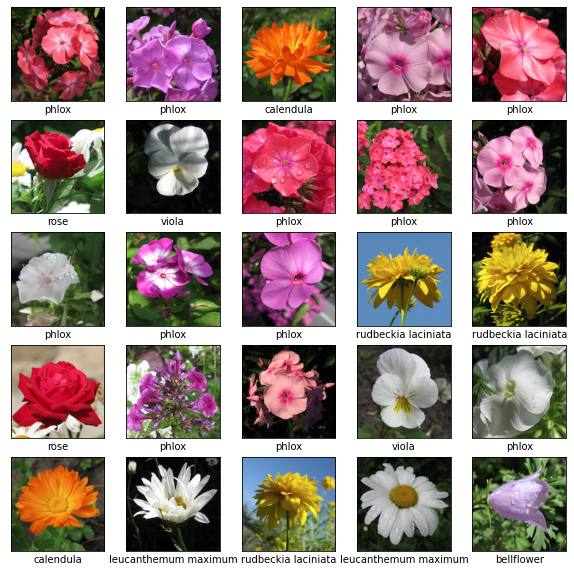

In [6]:
# Names of flower species are just for visualisation
flower_names = [
 'phlox','rose','calendula','iris','leucanthemum maximum',
    'bellflower','viola','rudbeckia laciniata','peony','aquilegia'
]
#
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_data[i])
    plt.xlabel(flower_names[labels_data[i]])
plt.show()

In [11]:
unique, counts = np.unique(labels_data, return_counts=True)
ticks = np.arange(len(counts))
np.unique(labels_data, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([21, 20, 19, 22, 21, 25, 23, 15, 26, 18], dtype=int64))

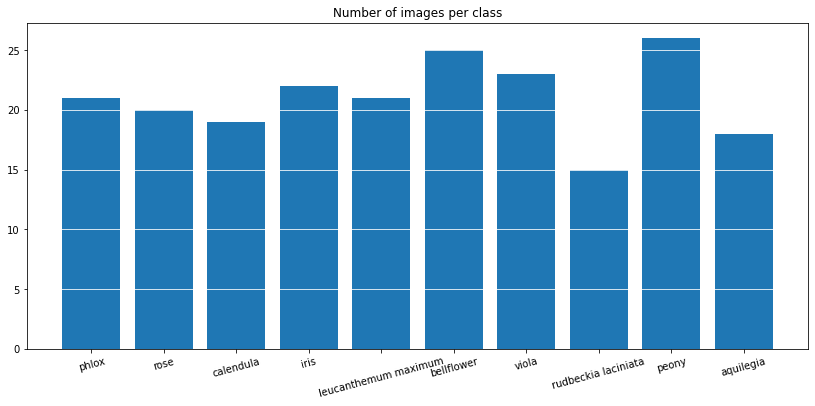

In [12]:
unique, counts = np.unique(labels_data, return_counts=True)
ticks = np.arange(len(counts))

plt.figure(figsize=(14,6))
plt.grid(color='w', axis='y')
plt.bar(ticks, counts)
plt.xticks(ticks, flower_names, rotation=15)
plt.title('Number of images per class')

plt.show()

We can see that the dataset is more or less balanced – there aren't any classes that have substantially more or fewer examples than others.

## 4. Splitting the data

Let's now shuffle the data and split it into two halves – one for training, and one for validation. Since we don't have a lot of data, let's split it equaly so that both training and in validation sets will have 105 images with ~10 images per class.

In [13]:
# Set a seed for reproducibility
seed = 1
def shuffle(a, b, seed=None):
    rand = np.random.RandomState(seed)
    p = rand.permutation(a.shape[0])
    return a[p], b[p]

x_data, y_data = shuffle(images_data, labels_data, seed=seed)

split_idx = int(0.5*x_data.shape[0])
#Training data (x=images, y=labels)
x_train, y_train = x_data[:split_idx], y_data[:split_idx]
#Validation data (x=images, y=labels)
x_val, y_val = x_data[split_idx:], y_data[split_idx:]

## 5. Image data augmentation

Now, let's get to the nitty gritties of working with Keras. As we discussed, it's important to provide data to the model in the right format. We'll use the [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class to do so. Let's go over its arguments:

1. `rotation_range`, `width_shift_range`, `height_shift_range`, `horizontal_flip` – those are augmentation parameters. Augmentation helps us introduce more variability from a small amount of data. Instead of feeding the original images, ImageDataGenerator will randomly apply transformations such as rotation (up to 20 degrees), shift along X and Y axes, and horizontal flipping (mirroring) of the image.
2. `data_format` – as you remember, the images have a format of 128×128×3 which corresponds to width×height×channels. The color channels are the last dimension. Thus we set the argument to `channels_last`.
3. `preprocessing_function` – since we use EfficientNet with pre-trained weights, it means the model has been already trained with images formatted in a certain way. Fortunately, efficientnet package provides `preprocess_input` function that will format the data in the same way it was formatted during training on the ImageNet data.

During validation, we don't want to alter the images because we want our model to perform well on the original ones. Thus, we'll create another ImageDataGenerator called `val_datagen` that omits augmentation.

In [18]:
#Augmentation- rotate, shift, flip
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    data_format='channels_last',
    preprocessing_function=efficientnet.preprocess_input
)

val_datagen = keras.preprocessing.image.ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function=efficientnet.preprocess_input
)

After defining the generators, we need to specify from where to take the data. We do so using the `.flow(x, y)` method of the generators. It will return a [Python Iterator](https://docs.python.org/3/howto/functional.html#iterators) object that represents a stream of batches of the processed data.

In [19]:
train_iterator = train_datagen.flow(x_train, y_train, batch_size=35)
val_iterator = val_datagen.flow(x_val, y_val, batch_size=105)


## 6. Model training

Okay, now to the exciting part – training our classifier! 
We are going to practice **transfer learning**, so we will first load a pre-trained model which we are going to use.

First, we have to define the model architecture and import pre-trained weights of the model.
Let's go through the important arguments:
1. `weights='noisy-student'` – specifies that we want to use the weights trained on ImageNet data and a large amount of unlabelled data using the novel [Noisy Student training approach](https://arxiv.org/pdf/1911.04252v4.pdf) (see the paper for more info).
2. `pooling='avg'` - after passing the images through EfficientNet, the resulting values will be averaged by channel to form a single vector for each image.
3. `include_top=False` – the pre-trained model also includes the layer that gives predictions for ImageNet classes. We don't want that, as we'll train our own top layer to produce class probabilities for the ten flower species. Thus, we have to set `include_top` to `False`.
4. `input_shape` - i.e., dimensions of an image

Here, we'll create `base_model` using the `EfficientNetB4` function. This is one of eight different EfficientNet models ranging from `B0` to `B7` that differ by size. The bigger the model, the more capacity it has for learning, but it also requires more computing power and memory.



In [20]:
input_shape=(128, 128, 3)

base_model = efficientnet.EfficientNetB4(
    weights='noisy-student',
    pooling='avg',
    include_top=False,
    input_shape=input_shape
)

71680000/71678424 [==============================] - 9s 0us/step


In [21]:
base_model.summary()

Model: "efficientnet-b4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 64, 64, 48)   1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 64, 64, 48)   192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 64, 64, 48)   0           stem_bn[0][0]                    
____________________________________________________________________________________

You can see that base_model model is quite complex!

We are going to freeze the layers of the base_model, so that we don't train them (don't backpropagate through them). This effectively makes base_model a feature extractor:

In [22]:
for layer in base_model.layers:
    layer.trainable = False

You can also choose to keep some layers of the network trainable. The deeper in the network, the more detail-oriented the layer. Allowing some of the last layers of the "feature extractor" to be trained can help to fine-tune the network.

In [23]:
#Uncomment if you want to set the last layers as trainable
#for layer in base_model.layers[-4:]:
#    layer.trainable = False

The last part is to add a classification layer to our neural network. For that, we add a fully-connected top layer with the number of ourputs defined by `num_classes`. The fully-connected layer takes `base_model.output` as an input. We use the 'softmax' activation for computing class probabilities.

In [24]:
num_classes=10

x = base_model.output
pred = keras.layers.Dense(num_classes, activation='softmax')(x)

# the Model class packs our architecture into one object
model = keras.models.Model(inputs=base_model.input, outputs=pred)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 64, 64, 48)   1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 64, 64, 48)   192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 64, 64, 48)   0           stem_bn[0][0]                    
______________________________________________________________________________________________

Let's now compile the model. Running it for the first time might take some time, as has to download the weights. After that, we have to call `.compile()` on our model, specifying the following:
1. `optimizer='adam'` – specifies that we want to use Adam optimization during training. It is a popular variant of stochastic gradient descent that speeds up convergence.
2. `loss=keras.losses.sparse_categorical_crossentropy` – the loss function we want to use in this case is the [cross entropy loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) used in categorical classification. It's called "sparse" since the true classes are specified as integers instead of as one-hot vectors.
3. `metrics=['accuracy']` – sets which metrics to track during training. 

In [26]:
model.compile(
    optimizer='adam',
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

> Did you get a «Kernel Restarting» error message here? If so, go to the first code cell of this notebook, uncomment the code, restart the kernel, and try again. If that doesn't work, contact your supervisor.

Now, let's train the model by calling `.fit()`. All we need to pass is our iterator and the number of iterations (epochs).

In [27]:
model.fit(train_iterator, epochs=30)

Epoch 1/30
3/3 [==============================] - 32s 852ms/step - loss: 2.3745 - accuracy: 0.1048
Epoch 2/30
3/3 [==============================] - 3s 926ms/step - loss: 2.1044 - accuracy: 0.2667
Epoch 3/30
3/3 [==============================] - 3s 804ms/step - loss: 1.9139 - accuracy: 0.3333
Epoch 4/30
3/3 [==============================] - 3s 785ms/step - loss: 1.7452 - accuracy: 0.3905
Epoch 5/30
3/3 [==============================] - 3s 732ms/step - loss: 1.6478 - accuracy: 0.5143
Epoch 6/30
3/3 [==============================] - 3s 761ms/step - loss: 1.5774 - accuracy: 0.5238
Epoch 7/30
3/3 [==============================] - 3s 791ms/step - loss: 1.3981 - accuracy: 0.5333
Epoch 8/30
3/3 [==============================] - 3s 819ms/step - loss: 1.3710 - accuracy: 0.5810
Epoch 9/30
3/3 [==============================] - 3s 788ms/step - loss: 1.2054 - accuracy: 0.7143
Epoch 10/30
3/3 [==============================] - 3s 812ms/step - loss: 1.1270 - accuracy: 0.7524
Epoch 11/30
3/3 [=

After training for 30 epochs, you should achieve a loss below 0.7 and accuracy above 80%. 

## 7. Validation

Now, let's test the model on our validation set by calling `.evaluate()`:

In [28]:
val_loss, val_acc = model.evaluate(val_iterator)
print(f'Validation loss: {round(val_loss*100, 4)}%\nValidation accuracy: {round(val_acc*100, 4)}%')

1/1 [==============================] - 11s 11s/step - loss: 0.6285 - accuracy: 0.8571
Validation loss: 62.8533%
Validation accuracy: 85.7143%


On the validation set, you should get accuracy in the range of 75% to 95%. Such a big uncertainty comes from the fact that we have an extremely small dataset. In a real-world project, I highly recommend using [cross-validation](https://developers.google.com/machine-learning/glossary#cross-validation) to test your models in such cases to get an accurate perspective on the model's performance.
In conclusion, having only 210 images from 10 classes, we achieved quite a high accuracy by leveraging the power of transfer learning.

## Self-test questions

_Oppgave: Svar på flervalgsspørsmålene 1–5 (vist nedenfor) i Canvas._

1. _According to the content provided in the notebook, what is EfficientNet?_
2. _What is the name of the dataset that Google's EfficientNet is trained on?_
3. _Which part of the convolutional neural network is retrained in the implementation of the notebook?_
4. _In the notebook, the part of the convolutional neural network represented by EfficientNet is …_
5. _Which statement is *not* true?_